# Same notebook as polarization.ipynb but rerun

# This new ML pipeline enables equal representation of each polarization state in each train, test, and validation dataset
### In the future, if needed, refactor into functions for efficiency

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [3]:
from core.getdata import *
from core.dataset import *
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [6]:
asd = DatasetPolar(ligands, polarization, replicas, size)

In [7]:
asd.labels.shape

(69552,)

In [8]:
m0 = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [9]:
print(len(m0), len(ib), len(ig), len(i0), len(i3), len(i4))

11592 11592 11592 11592 11592 11592


In [10]:
m0_train, m0_val, m0_test = torch.utils.data.random_split(m0, [6956, 2318, 2318])
ib_train, ib_val, ib_test = torch.utils.data.random_split(ib, [6956, 2318, 2318])
ig_train, ig_val, ig_test = torch.utils.data.random_split(ig, [6956, 2318, 2318])
i0_train, i0_val, i0_test = torch.utils.data.random_split(i0, [6956, 2318, 2318])
i3_train, i3_val, i3_test = torch.utils.data.random_split(i3, [6956, 2318, 2318])
i4_train, i4_val, i4_test = torch.utils.data.random_split(i4, [6956, 2318, 2318])

In [11]:
# extract all data and labels from each torch subset object and refactor into my own objects

def extract_xy(subsets):
    train, val, test = subsets # unpack tuple
    train_X = [item[0] for item in train]
    train_Y = [item[1] for item in train]
    val_X = [item[0] for item in val]
    val_Y = [item[1] for item in val]
    test_X = [item[0] for item in test]
    test_Y = [item[1] for item in test]
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [12]:
m0_train_X, m0_train_Y, m0_val_X, m0_val_Y, m0_test_X, m0_test_Y = extract_xy((m0_train, m0_val, m0_test))
ib_train_X, ib_train_Y, ib_val_X, ib_val_Y, ib_test_X, ib_test_Y = extract_xy((ib_train, ib_val, ib_test))
ig_train_X, ig_train_Y, ig_val_X, ig_val_Y, ig_test_X, ig_test_Y = extract_xy((ig_train, ig_val, ig_test))
i0_train_X, i0_train_Y, i0_val_X, i0_val_Y, i0_test_X, i0_test_Y = extract_xy((i0_train, i0_val, i0_test))
i3_train_X, i3_train_Y, i3_val_X, i3_val_Y, i3_test_X, i3_test_Y = extract_xy((i3_train, i3_val, i3_test))
i4_train_X, i4_train_Y, i4_val_X, i4_val_Y, i4_test_X, i4_test_Y = extract_xy((i4_train, i4_val, i4_test))

In [13]:
# split into 60/20/20 for each polarization dataset
# more empirical method to analyze model metrics across each polarization

# X = np.vstack([m0.data, ib.data, ig.data, i0.data, i3.data, i4.data])
# Y = np.hstack([m0.labels, ib.labels, ig.labels, i0.labels, i3.labels, i4.labels])

In [14]:
class TorchData:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
# need to concat all train_X and train_Y into one dataset for training
train_X = np.vstack([m0_train_X, ib_train_X, ig_train_X, i0_train_X, i3_train_X, i4_train_X])
train_Y = np.hstack([m0_train_Y, ib_train_Y, ig_train_Y, i0_train_Y, i3_train_Y, i4_train_Y])

val_X = np.vstack([m0_val_X, ib_val_X, ig_val_X, i0_val_X, i3_val_X, i4_val_X])
val_Y = np.hstack([m0_val_Y, ib_val_Y, ig_val_Y, i0_val_Y, i3_val_Y, i4_val_Y])

test_X = np.vstack([m0_test_X, ib_test_X, ig_test_X, i0_test_X, i3_test_X, i4_test_X])
test_Y = np.hstack([m0_test_Y, ib_test_Y, ig_test_Y, i0_test_Y, i3_test_Y, i4_test_Y])

In [16]:
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

(41736, 98, 1) (41736,)
(13908, 98, 1) (13908,)
(13908, 98, 1) (13908,)


In [17]:
train = TorchData(train_X, train_Y)
val = TorchData(val_X, val_Y)
test = TorchData(test_X, test_Y)

In [18]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [19]:
# hyperparameters
input_size = 1
hidden_size = 98
output_size = 9

lr = 0.001
n_epochs = 70
batch_size = 64
device = torch.device('cuda')

In [20]:
net = LSTM(input_size=input_size, hidden_sizes=hidden_size, output_size=output_size, num_layers=3, device=device)

In [21]:
net.train()

LSTM(
  (lstm): LSTM(1, 98, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [22]:
trainer = LSTMTrainer(model=net, device=device)

In [23]:
trainer.train(trainloader, valloader, batch_size=batch_size, n_epochs=n_epochs)

  1%|█▏                                                                                 | 1/70 [00:08<10:12,  8.88s/it]

Epoch 001: | Training Loss: 2.1889120849679475 | Validation Loss: 2.1973868739714315


  3%|██▎                                                                                | 2/70 [00:16<09:27,  8.35s/it]

Epoch 002: | Training Loss: 2.1930736053227284 | Validation Loss: 2.1978027426868403


  4%|███▌                                                                               | 3/70 [00:25<09:14,  8.28s/it]

Epoch 003: | Training Loss: 2.1874619360904783 | Validation Loss: 2.1631973741251396


  6%|████▋                                                                              | 4/70 [00:34<09:48,  8.92s/it]

Epoch 004: | Training Loss: 2.1542148907735923 | Validation Loss: 2.0673160498295355


  7%|█████▉                                                                             | 5/70 [00:45<10:12,  9.42s/it]

Epoch 005: | Training Loss: 2.0848125317925517 | Validation Loss: 2.076764787009003


  9%|███████                                                                            | 6/70 [00:55<10:21,  9.72s/it]

Epoch 006: | Training Loss: 2.1145666052700003 | Validation Loss: 2.1232732501598672


 10%|████████▎                                                                          | 7/70 [01:05<10:26,  9.95s/it]

Epoch 007: | Training Loss: 2.0456049046144003 | Validation Loss: 1.953678115245399


 11%|█████████▍                                                                         | 8/70 [01:16<10:24, 10.07s/it]

Epoch 008: | Training Loss: 1.8875662674400013 | Validation Loss: 1.78723481816983


 13%|██████████▋                                                                        | 9/70 [01:26<10:16, 10.11s/it]

Epoch 009: | Training Loss: 1.7513390348662279 | Validation Loss: 1.7121539208867134


 14%|███████████▋                                                                      | 10/70 [01:36<10:10, 10.18s/it]

Epoch 010: | Training Loss: 1.6744175568839128 | Validation Loss: 1.6248248864751342


 16%|████████████▉                                                                     | 11/70 [01:47<10:05, 10.26s/it]

Epoch 011: | Training Loss: 1.617750819572811 | Validation Loss: 1.6186249250665716


 17%|██████████████                                                                    | 12/70 [01:57<09:54, 10.25s/it]

Epoch 012: | Training Loss: 1.572113661817168 | Validation Loss: 1.5452086012297814


 19%|███████████████▏                                                                  | 13/70 [02:07<09:45, 10.28s/it]

Epoch 013: | Training Loss: 1.532598544225941 | Validation Loss: 1.515818202167476


 20%|████████████████▍                                                                 | 14/70 [02:18<09:36, 10.30s/it]

Epoch 014: | Training Loss: 1.5007984457483337 | Validation Loss: 1.5186028650047583


 21%|█████████████████▌                                                                | 15/70 [02:28<09:29, 10.35s/it]

Epoch 015: | Training Loss: 1.4696081975335185 | Validation Loss: 1.4428245408819356


 23%|██████████████████▋                                                               | 16/70 [02:39<09:20, 10.38s/it]

Epoch 016: | Training Loss: 1.4330528815709065 | Validation Loss: 1.4355539345960004


 24%|███████████████████▉                                                              | 17/70 [02:49<09:12, 10.42s/it]

Epoch 017: | Training Loss: 1.4090445749975091 | Validation Loss: 1.4071788651133896


 26%|█████████████████████                                                             | 18/70 [03:00<09:02, 10.43s/it]

Epoch 018: | Training Loss: 1.3665533096830476 | Validation Loss: 1.3700239149802322


 27%|██████████████████████▎                                                           | 19/70 [03:10<08:52, 10.45s/it]

Epoch 019: | Training Loss: 1.336368304299359 | Validation Loss: 1.3768178694838777


 29%|███████████████████████▍                                                          | 20/70 [03:20<08:40, 10.40s/it]

Epoch 020: | Training Loss: 1.3060707545755104 | Validation Loss: 1.323083139340812


 30%|████████████████████████▌                                                         | 21/70 [03:31<08:29, 10.40s/it]

Epoch 021: | Training Loss: 1.281182594722847 | Validation Loss: 1.3037763309041295


 31%|█████████████████████████▊                                                        | 22/70 [03:41<08:20, 10.42s/it]

Epoch 022: | Training Loss: 1.2551180764142806 | Validation Loss: 1.2984894194187375


 33%|██████████████████████████▉                                                       | 23/70 [03:52<08:08, 10.40s/it]

Epoch 023: | Training Loss: 1.228371306090041 | Validation Loss: 1.2907694291084184


 34%|████████████████████████████                                                      | 24/70 [04:02<07:59, 10.41s/it]

Epoch 024: | Training Loss: 1.2044623845569207 | Validation Loss: 1.2519876494866993


 36%|█████████████████████████████▎                                                    | 25/70 [04:12<07:46, 10.37s/it]

Epoch 025: | Training Loss: 1.1954554981148444 | Validation Loss: 1.2469040478041413


 37%|██████████████████████████████▍                                                   | 26/70 [04:23<07:35, 10.36s/it]

Epoch 026: | Training Loss: 1.158438485395306 | Validation Loss: 1.2324609064727747


 39%|███████████████████████████████▋                                                  | 27/70 [04:33<07:26, 10.38s/it]

Epoch 027: | Training Loss: 1.1377802214615196 | Validation Loss: 1.2416058136235684


 40%|████████████████████████████████▊                                                 | 28/70 [04:43<07:15, 10.37s/it]

Epoch 028: | Training Loss: 1.1155551042162442 | Validation Loss: 1.2086375711161061


 41%|█████████████████████████████████▉                                                | 29/70 [04:54<07:04, 10.35s/it]

Epoch 029: | Training Loss: 1.098691468855871 | Validation Loss: 1.1750990639039136


 43%|███████████████████████████████████▏                                              | 30/70 [05:04<06:55, 10.39s/it]

Epoch 030: | Training Loss: 1.0737426460793336 | Validation Loss: 1.1641077287153367


 44%|████████████████████████████████████▎                                             | 31/70 [05:15<06:45, 10.40s/it]

Epoch 031: | Training Loss: 1.047389587892325 | Validation Loss: 1.1691393803019043


 46%|█████████████████████████████████████▍                                            | 32/70 [05:25<06:36, 10.43s/it]

Epoch 032: | Training Loss: 1.0501798065935488 | Validation Loss: 1.1767427235021504


 47%|██████████████████████████████████████▋                                           | 33/70 [05:36<06:25, 10.43s/it]

Epoch 033: | Training Loss: 1.0002402193148323 | Validation Loss: 1.1269328030971213


 49%|███████████████████████████████████████▊                                          | 34/70 [05:46<06:15, 10.43s/it]

Epoch 034: | Training Loss: 0.9888312730818394 | Validation Loss: 1.1534584361478823


 50%|█████████████████████████████████████████                                         | 35/70 [05:56<06:04, 10.42s/it]

Epoch 035: | Training Loss: 0.9609363242458968 | Validation Loss: 1.1336802263325507


 51%|██████████████████████████████████████████▏                                       | 36/70 [06:07<05:54, 10.41s/it]

Epoch 036: | Training Loss: 0.9241322116501298 | Validation Loss: 1.1073195565184322


 53%|███████████████████████████████████████████▎                                      | 37/70 [06:17<05:43, 10.41s/it]

Epoch 037: | Training Loss: 0.913897993371096 | Validation Loss: 1.1154564118713415


 54%|████████████████████████████████████████████▌                                     | 38/70 [06:28<05:33, 10.43s/it]

Epoch 038: | Training Loss: 0.8778421954575578 | Validation Loss: 1.088725776027102


 56%|█████████████████████████████████████████████▋                                    | 39/70 [06:38<05:22, 10.40s/it]

Epoch 039: | Training Loss: 0.8596977545875503 | Validation Loss: 1.0619839227527654


 57%|██████████████████████████████████████████████▊                                   | 40/70 [06:48<05:11, 10.39s/it]

Epoch 040: | Training Loss: 0.8367036895036333 | Validation Loss: 1.0642258038214587


 59%|████████████████████████████████████████████████                                  | 41/70 [06:59<05:02, 10.44s/it]

Epoch 041: | Training Loss: 0.8187460329549053 | Validation Loss: 1.0577771075821798


 60%|█████████████████████████████████████████████████▏                                | 42/70 [07:09<04:51, 10.42s/it]

Epoch 042: | Training Loss: 0.7924737356158165 | Validation Loss: 1.06132132443813


 61%|██████████████████████████████████████████████████▎                               | 43/70 [07:20<04:41, 10.43s/it]

Epoch 043: | Training Loss: 0.768273050031107 | Validation Loss: 1.0553244601149079


 63%|███████████████████████████████████████████████████▌                              | 44/70 [07:30<04:31, 10.44s/it]

Epoch 044: | Training Loss: 0.7609518707072388 | Validation Loss: 1.060218673507008


 64%|████████████████████████████████████████████████████▋                             | 45/70 [07:41<04:20, 10.42s/it]

Epoch 045: | Training Loss: 0.7194276918952351 | Validation Loss: 1.0828728238377003


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [07:51<04:10, 10.46s/it]

Epoch 046: | Training Loss: 0.6967540323551727 | Validation Loss: 1.0457567515176371


 67%|███████████████████████████████████████████████████████                           | 47/70 [08:00<03:49,  9.96s/it]

Epoch 047: | Training Loss: 0.6873814677662725 | Validation Loss: 1.0316449411965292


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [08:08<03:26,  9.40s/it]

Epoch 048: | Training Loss: 0.6775672014055354 | Validation Loss: 1.015015475793716


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [08:16<03:08,  9.00s/it]

Epoch 049: | Training Loss: 0.6739654580265237 | Validation Loss: 1.095986216986945


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [08:24<02:53,  8.68s/it]

Epoch 050: | Training Loss: 0.6381023169294068 | Validation Loss: 1.0288599893587445


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [08:32<02:40,  8.46s/it]

Epoch 051: | Training Loss: 0.6027682468317916 | Validation Loss: 1.0207471795585177


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [08:40<02:29,  8.31s/it]

Epoch 052: | Training Loss: 0.5938343627985915 | Validation Loss: 0.9821951851385449


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [08:48<02:19,  8.23s/it]

Epoch 053: | Training Loss: 0.578515231677803 | Validation Loss: 1.0509435529008917


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [08:56<02:10,  8.14s/it]

Epoch 054: | Training Loss: 0.5558634587259789 | Validation Loss: 0.9956787130154601


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [09:04<02:01,  8.11s/it]

Epoch 055: | Training Loss: 0.5285924014280255 | Validation Loss: 1.013893400583792


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [09:12<01:52,  8.06s/it]

Epoch 056: | Training Loss: 0.5111360482837303 | Validation Loss: 0.9800931499638689


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [09:20<01:44,  8.02s/it]

Epoch 057: | Training Loss: 0.5145039835211694 | Validation Loss: 0.9798763425798591


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [09:28<01:36,  8.00s/it]

Epoch 058: | Training Loss: 0.47754434490459435 | Validation Loss: 0.9821885999189605


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [09:36<01:27,  7.98s/it]

Epoch 059: | Training Loss: 0.47977415699323506 | Validation Loss: 0.9806669482944208


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [09:44<01:20,  8.00s/it]

Epoch 060: | Training Loss: 0.4758664145723419 | Validation Loss: 0.9834228439615407


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [09:52<01:12,  8.03s/it]

Epoch 061: | Training Loss: 0.437591088653341 | Validation Loss: 1.0040978115359578


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [10:00<01:04,  8.02s/it]

Epoch 062: | Training Loss: 0.42626816196335765 | Validation Loss: 0.9722456457691455


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [10:08<00:56,  8.00s/it]

Epoch 063: | Training Loss: 0.42380689518101183 | Validation Loss: 0.9797316317984818


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [10:16<00:48,  8.02s/it]

Epoch 064: | Training Loss: 0.4373308786891321 | Validation Loss: 0.9407964246262104


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [10:24<00:40,  8.02s/it]

Epoch 065: | Training Loss: 0.42362479425133825 | Validation Loss: 0.9794571328600612


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [10:32<00:32,  8.03s/it]

Epoch 066: | Training Loss: 0.3799879014104103 | Validation Loss: 0.9804137891859089


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [10:40<00:24,  8.02s/it]

Epoch 067: | Training Loss: 0.3778781495406471 | Validation Loss: 0.9891856892393269


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [10:48<00:15,  7.99s/it]

Epoch 068: | Training Loss: 0.37539518541252814 | Validation Loss: 0.9940326398392336


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [10:56<00:07,  7.95s/it]

Epoch 069: | Training Loss: 0.38402905088106304 | Validation Loss: 0.9828211386269385


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [11:04<00:00,  9.49s/it]

Epoch 070: | Training Loss: 0.3279603679092518 | Validation Loss: 0.9926595239464296


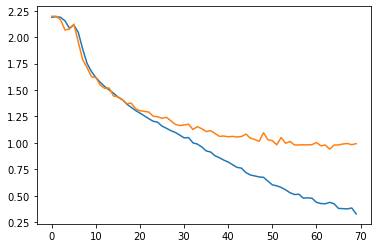

In [24]:
# visualize training/validation loss
plt.plot(trainer.loss_history[0])
plt.plot(trainer.loss_history[1])

# some forgetting, could rerun

In [25]:
# trainer.evaluate with testloader
prob, pred, true = trainer.evaluate(testloader)

In [26]:
from sklearn.metrics import classification_report

In [27]:
cr = classification_report(true, pred, target_names=ligands)

In [28]:
print(cr) # similar results to apeksha's model ~ 55% accuracy

              precision    recall  f1-score   support

         TNF       0.74      0.71      0.72      1526
         R84       0.84      0.79      0.81      1563
         PIC       0.80      0.79      0.80      1552
         P3K       0.73      0.76      0.75      1568
         FLA       0.69      0.64      0.67      1549
         CpG       0.67      0.66      0.67      1506
         FSL       0.66      0.65      0.66      1521
         LPS       0.64      0.71      0.67      1568
         UST       0.96      1.00      0.98      1555

    accuracy                           0.75     13908
   macro avg       0.75      0.75      0.75     13908
weighted avg       0.75      0.75      0.75     13908



In [29]:
fraction = Fraction(true, prob)

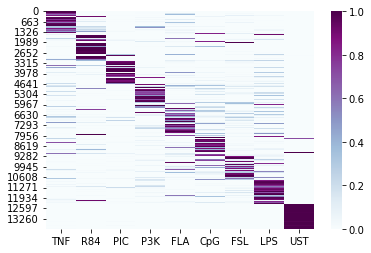

In [30]:
cf = sns.heatmap(fraction, cmap="BuPu", xticklabels=ligands)

## Polarization State Analysis

In [31]:
# refactor each polarization test_X and test_Y into torchdata object
# evaluate each one separately then concat and evaluate holistically

m0_test = TorchData(m0_test_X, m0_test_Y)
ib_test = TorchData(ib_test_X, ib_test_Y)
ig_test = TorchData(ig_test_X, ig_test_Y)
i0_test = TorchData(i0_test_X, i0_test_Y)
i3_test = TorchData(i3_test_X, i3_test_Y)
i4_test = TorchData(i4_test_X, i4_test_Y)

In [32]:
m0_loader = torch.utils.data.DataLoader(m0_test, batch_size=64, shuffle=True)
ib_loader = torch.utils.data.DataLoader(ib_test, batch_size=64, shuffle=True)
ig_loader = torch.utils.data.DataLoader(ig_test, batch_size=64, shuffle=True)
i0_loader = torch.utils.data.DataLoader(i0_test, batch_size=64, shuffle=True)
i3_loader = torch.utils.data.DataLoader(i3_test, batch_size=64, shuffle=True)
i4_loader = torch.utils.data.DataLoader(i4_test, batch_size=64, shuffle=True)

In [33]:
m0_prob, m0_pred, m0_true = trainer.evaluate(m0_loader)

In [34]:
ib_prob, ib_pred, ib_true = trainer.evaluate(ib_loader)

In [35]:
ig_prob, ig_pred, ig_true = trainer.evaluate(ig_loader)

In [36]:
i0_prob, i0_pred, i0_true = trainer.evaluate(i0_loader)

In [37]:
i3_prob, i3_pred, i3_true = trainer.evaluate(i3_loader)

In [38]:
i4_prob, i4_pred, i4_true = trainer.evaluate(i4_loader)

### M0

              precision    recall  f1-score     support
TNF            0.683206  0.716000  0.699219   250.00000
R84            0.780142  0.830189  0.804388   265.00000
PIC            0.817544  0.896154  0.855046   260.00000
P3K            0.535593  0.683983  0.600760   231.00000
FLA            0.612000  0.566667  0.588462   270.00000
CpG            0.504132  0.480315  0.491935   254.00000
FSL            0.512821  0.400000  0.449438   250.00000
LPS            0.686992  0.605735  0.643810   279.00000
UST            0.992337  1.000000  0.996154   259.00000
accuracy       0.687230  0.687230  0.687230     0.68723
macro avg      0.680530  0.686560  0.681023  2318.00000
weighted avg   0.683349  0.687230  0.682863  2318.00000


<AxesSubplot:>

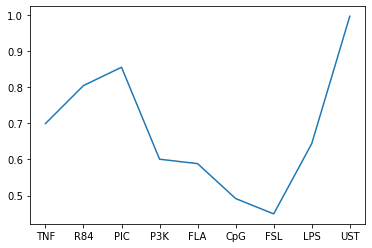

In [39]:
m0_cr = classification_report(m0_true, m0_pred, target_names=ligands, output_dict=True)
m0_crdf = pd.DataFrame(m0_cr).transpose()
print(m0_crdf)

m0_crdf[:9]['f1-score'].plot()

### ib

              precision    recall  f1-score      support
TNF            0.698565  0.605809  0.648889   241.000000
R84            0.881633  0.818182  0.848723   264.000000
PIC            0.732218  0.670498  0.700000   261.000000
P3K            0.803738  0.659004  0.724211   261.000000
FLA            0.683824  0.712644  0.697936   261.000000
CpG            0.693396  0.592742  0.639130   248.000000
FSL            0.614035  0.683594  0.646950   256.000000
LPS            0.584270  0.825397  0.684211   252.000000
UST            0.958042  1.000000  0.978571   274.000000
accuracy       0.732959  0.732959  0.732959     0.732959
macro avg      0.738858  0.729763  0.729847  2318.000000
weighted avg   0.741744  0.732959  0.732959  2318.000000


<AxesSubplot:>

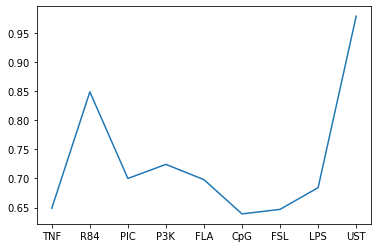

In [40]:
ib_cr = classification_report(ib_true, ib_pred, target_names=ligands, output_dict=True)
ib_crdf = pd.DataFrame(ib_cr).transpose()
print(ib_crdf)

ib_crdf[:9]['f1-score'].plot()

### ig

              precision    recall  f1-score      support
TNF            0.790179  0.678161  0.729897   261.000000
R84            0.769504  0.783394  0.776386   277.000000
PIC            0.820755  0.679688  0.743590   256.000000
P3K            0.589091  0.632812  0.610169   256.000000
FLA            0.561111  0.410569  0.474178   246.000000
CpG            0.567568  0.578740  0.573099   254.000000
FSL            0.544304  0.483146  0.511905   267.000000
LPS            0.474619  0.739130  0.578053   253.000000
UST            0.972549  1.000000  0.986083   248.000000
accuracy       0.665229  0.665229  0.665229     0.665229
macro avg      0.676631  0.665071  0.664818  2318.000000
weighted avg   0.676922  0.665229  0.665148  2318.000000


<AxesSubplot:>

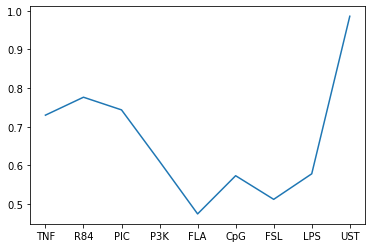

In [41]:
ig_cr = classification_report(ig_true, ig_pred, target_names=ligands, output_dict=True)
ig_crdf = pd.DataFrame(ig_cr).transpose()
print(ig_crdf)

ig_crdf[:9]['f1-score'].plot()

### i0

              precision    recall  f1-score      support
TNF            0.746888  0.708661  0.727273   254.000000
R84            0.878924  0.734082  0.800000   267.000000
PIC            0.840304  0.853282  0.846743   259.000000
P3K            0.782918  0.805861  0.794224   273.000000
FLA            0.663507  0.544747  0.598291   257.000000
CpG            0.744262  0.883268  0.807829   257.000000
FSL            0.742373  0.872510  0.802198   251.000000
LPS            0.607287  0.597610  0.602410   251.000000
UST            0.988095  1.000000  0.994012   249.000000
accuracy       0.777394  0.777394  0.777394     0.777394
macro avg      0.777173  0.777780  0.774775  2318.000000
weighted avg   0.777547  0.777394  0.774761  2318.000000


<AxesSubplot:>

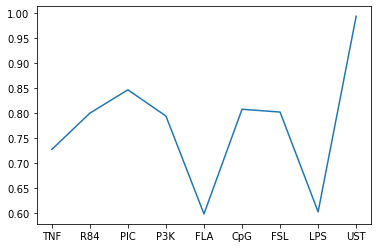

In [42]:
i0_cr = classification_report(i0_true, i0_pred, target_names=ligands, output_dict=True)
i0_crdf = pd.DataFrame(i0_cr).transpose()
print(i0_crdf)

i0_crdf[:9]['f1-score'].plot()

### i3

              precision    recall  f1-score      support
TNF            0.776923  0.789062  0.782946   256.000000
R84            0.860000  0.849802  0.854871   253.000000
PIC            0.819495  0.866412  0.842301   262.000000
P3K            0.810409  0.822642  0.816479   265.000000
FLA            0.772727  0.764045  0.768362   267.000000
CpG            0.738589  0.712000  0.725051   250.000000
FSL            0.745968  0.745968  0.745968   248.000000
LPS            0.811966  0.725191  0.766129   262.000000
UST            0.927273  1.000000  0.962264   255.000000
accuracy       0.808456  0.808456  0.808456     0.808456
macro avg      0.807039  0.808347  0.807152  2318.000000
weighted avg   0.807202  0.808456  0.807284  2318.000000


<AxesSubplot:>

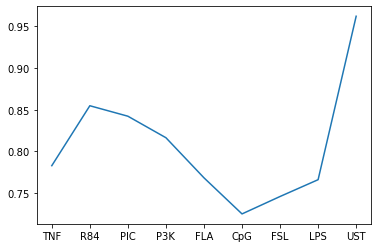

In [43]:
i3_cr = classification_report(i3_true, i3_pred, target_names=ligands, output_dict=True)
i3_crdf = pd.DataFrame(i3_cr).transpose()
print(i3_crdf)

i3_crdf[:9]['f1-score'].plot()

### i4

              precision    recall  f1-score      support
TNF            0.738636  0.738636  0.738636   264.000000
R84            0.898396  0.708861  0.792453   237.000000
PIC            0.743590  0.799213  0.770398   254.000000
P3K            0.872964  0.950355  0.910017   282.000000
FLA            0.776173  0.866935  0.819048   248.000000
CpG            0.784141  0.732510  0.757447   243.000000
FSL            0.783898  0.742972  0.762887   249.000000
LPS            0.813953  0.774908  0.793951   271.000000
UST            0.934256  1.000000  0.966011   270.000000
accuracy       0.816221  0.816221  0.816221     0.816221
macro avg      0.816223  0.812710  0.812316  2318.000000
weighted avg   0.817095  0.816221  0.814600  2318.000000


<AxesSubplot:>

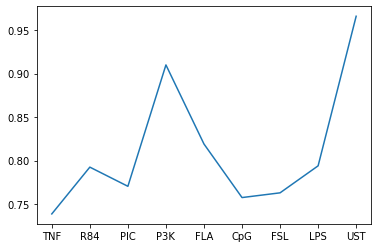

In [44]:
i4_cr = classification_report(i4_true, i4_pred, target_names=ligands, output_dict=True)
i4_crdf = pd.DataFrame(i4_cr).transpose()
print(i4_crdf)

i4_crdf[:9]['f1-score'].plot()

## Holistic

In [45]:
total_f1 = pd.concat([m0_crdf['f1-score'], ib_crdf['f1-score'], ig_crdf['f1-score'], i0_crdf['f1-score'], i3_crdf['f1-score'], i4_crdf['f1-score']], axis=1)
total_f1 = total_f1.set_axis(['M0', 'IB', 'IG', 'I0', 'I3', 'I4'], axis=1)

In [46]:
total_f1.iloc[:9]

,M0,IB,IG,I0,I3,I4
TNF,0.699219,0.648889,0.729897,0.727273,0.782946,0.738636
R84,0.804388,0.848723,0.776386,0.800000,0.854871,0.792453
PIC,0.855046,0.700000,0.743590,0.846743,0.842301,0.770398
P3K,0.600760,0.724211,0.610169,0.794224,0.816479,0.910017
FLA,0.588462,0.697936,0.474178,0.598291,0.768362,0.819048
CpG,0.491935,0.639130,0.573099,0.807829,0.725051,0.757447
FSL,0.449438,0.646950,0.511905,0.802198,0.745968,0.762887
LPS,0.643810,0.684211,0.578053,0.602410,0.766129,0.793951
UST,0.996154,0.978571,0.986083,0.994012,0.962264,0.966011


<AxesSubplot:>

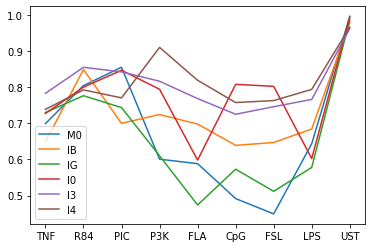

In [47]:
total_f1.iloc[:9].plot()

<AxesSubplot:>

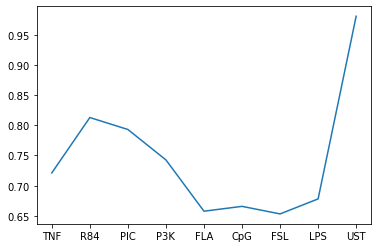

In [48]:
np.mean(total_f1.iloc[:9], axis=1).plot()

<AxesSubplot:>

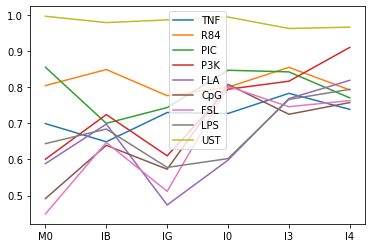

In [49]:
total_f1.iloc[:9].transpose().plot()

In [50]:
# average f1 score for all ligands across each polarization state
np.mean(total_f1.iloc[:9])

M0    0.681023
IB    0.729847
IG    0.664818
I0    0.774775
I3    0.807152
I4    0.812316
dtype: float64

<AxesSubplot:>

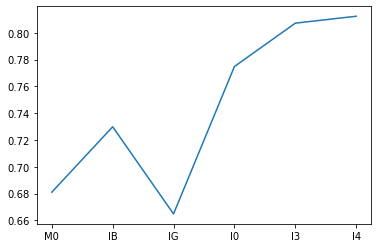

In [51]:
np.mean(total_f1.iloc[:9]).plot()